# California Census

Se pretende ilustrar la regresión utilizando SVMs aplicando tanto la $\epsilon$‐SVR como la $\nu$‐SVR sobre los datos del censo de California por grupos de bloques de vivienda con el objetivo de predecir los precios medios de la vivienda. También se deberá de utilizar una red neuronal artificial para resolver el problema.

La variable dependiente es $ln(median\_house\_value)$, y se tiene que ajustar el siguiente modelo: 

$$ln(median\_house\_value) = a_1 + a_2 \cdot median\_income + a_3 \cdot median\_income^2 + a_4 \cdot median\_income^3 + a_5 \cdot ln(median\_age) + a_6 \cdot ln(total\_room / population) + a_7 \cdot ln(total\_bedrooms / population) + a_8 \cdot ln(population / households) + a_9 \cdot ln(households)$$

<br>

<div class="panel panel-success">
    <div class='panel-heading'>
        <h2>Índice</h2>
    </div>
    <div class='panel-body'>
        <ol type="A">
            <li><a href="#carga">Carga de datos</a></li>
            <li><a href="#analisis">Análisis exploratorio de los datos</a></li>
            <li><a href="#seleccion">Selección del modelo de datos</a></li>
            <li><a href="#train-test">Separación de datos de entrenamiento y prueba</a></li>
            <li><a href="#regresion-lineal">Regresión lineal</a></li>
                <ol type="B">
                    <li><a href="#regresion-lineal-basica">Regresión lineal básica</a></li>
                    <li><a href="#regresion-lineal-polinomial">Regresión lineal con variables polinomiales</a></li>
                </ol>
            <li><a href="#arboles-decision">Árboles de decisión</a></li>
                <ol type="B">
                    <li><a href="#arbol-decision-basico">Árbol de decisión básico</a></li>
                    <li><a href="#arbol-decision-gridsearch">Árbol de decisión mediante GridSearchCV</a></li>
                    <li><a href="#arbol-decision-variables">Visualización de las variables más importantes</a></li>
                </ol>
            <li><a href="#bagging">Bagging</a></li>
            <li><a href="#random-forest">Random Forest</a></li>
                <ol type="B">
                    <li><a href="#random-forest-variables">Visualización de las variables más importantes</a></li>
                </ol>
            <li><a href="#boosting">Boosting</a></li>
            <li><a href=#svm>SVM</a></li>
                <ol type=B>
                    <li><a href=#epsvm-lineal>$\epsilon$-SVM con Kernel lineal</a></li>
                    <li><a href=#epsvm-rbf>$\epsilon$-SVM con Kernel RBF</a></li>
                    <li><a href=#epsvm-poly>$\epsilon$-SVM con Kernel polinomial</a></li>
                    <li><a href=#nusvm-rbf>$\nu$-SVM con Kernel RBF</a></li>
                    <li><a href=#svm-result>Conclusiones de SVM</a></li>
                </ol>
            <li><a href=#neural-net>Redes neuronales</a></li>
            <li><a href=#results>Resultados finales</a></li>
        </ol>
    </div>
</div>

# 1. Carga de los datos <a class="anchor" id="carga"></a>

Se realiza una carga de las librerías necesarias para este proyecto.

In [19]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline

<br>
Se lee el fichero CSV **census-dataset** para cargar los datos en un dataframe de Pandas.

In [20]:
df = pd.read_csv("census-dataset.csv", sep=",")
df.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600,8.3252,41,880,129,322,126,37.88,-122.23
1,358500,8.3014,21,7099,1106,2401,1138,37.86,-122.22
2,352100,7.2574,52,1467,190,496,177,37.85,-122.24
3,341300,5.6431,52,1274,235,558,219,37.85,-122.25
4,342200,3.8462,52,1627,280,565,259,37.85,-122.25


<br>
Eliminamos las variables **latitude** y **longitude** ya que no serán necesarios para este modelo.

In [21]:
df = df.drop(['latitude', 'longitude'], axis=1)

# 2. Análisis exploratorio de los datos <a class="anchor" id="analisis"></a>

El conjunto de datos se compone por 20.640 registros y 7 columnas.

In [22]:
df.shape

(20640, 7)

<br>
Los tipos de las columnas del dataframe son los siguientes:

In [23]:
df.dtypes

median_house_value      int64
median_income         float64
housing_median_age      int64
total_rooms             int64
total_bedrooms          int64
population              int64
households              int64
dtype: object

<br>
A continuación, se muestra las estadísticas descriptivas de cada columna con valores continuos que resume la tendencia, dispersión y forma de la distribución del conjunto de datos, excluyendo los valores nulos.

In [24]:
df.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000


### Valores nulos

A continuacón, se demuestra que no hay ningún valor nulo en el dataset.

In [25]:
null_data = df.isnull().sum()
null_data.sort_values(ascending=False)

households            0
population            0
total_bedrooms        0
total_rooms           0
housing_median_age    0
median_income         0
median_house_value    0
dtype: int64

### Correlación entre variables

In [26]:
corr = df.corr()
corr

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households
median_house_value,1.000000,0.688075,0.105623,0.134153,0.050594,-0.024650,0.065843
median_income,0.688075,1.000000,-0.119034,0.198050,-0.008093,0.004834,0.013033
housing_median_age,0.105623,-0.119034,1.000000,-0.361262,-0.320485,-0.296244,-0.302916
total_rooms,0.134153,0.198050,-0.361262,1.000000,0.929893,0.857126,0.918484
total_bedrooms,0.050594,-0.008093,-0.320485,0.929893,1.000000,0.878026,0.979829
population,-0.024650,0.004834,-0.296244,0.857126,0.878026,1.000000,0.907222
households,0.065843,0.013033,-0.302916,0.918484,0.979829,0.907222,1.000000


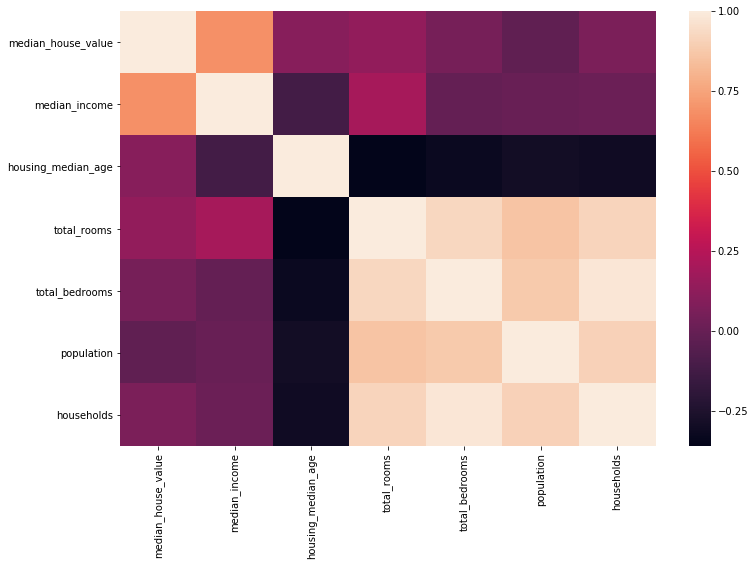

In [27]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

<br>
La variable objetivo **median_house_value** tiene una alta correlación con la variable **median_income**, por lo que probablemente esta sea la variable con más peso en los modelos.

Entre las variable **total_rooms**, **total_bedrooms**, **population** y **households** también hay una alta correlación, lo que podría provocar un problema de multicolinealidad.

A continuación, se generan los diagramas de cajas para cada una de las variables.

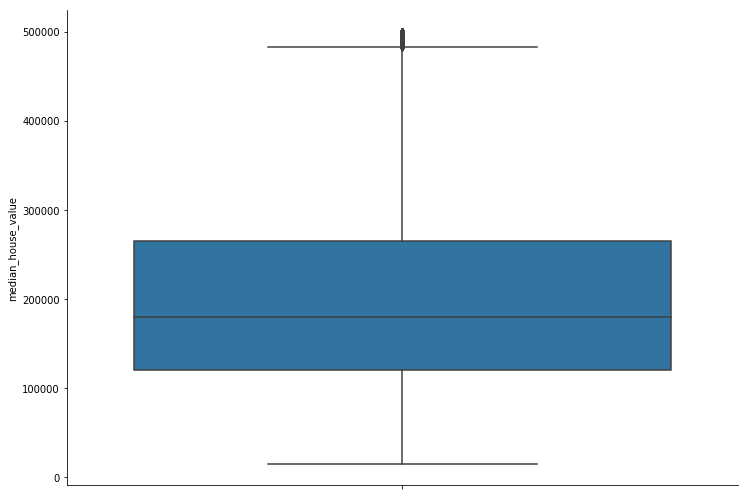

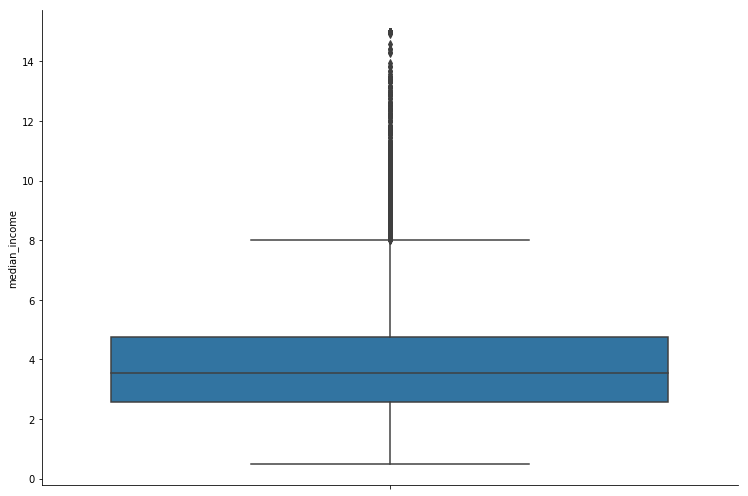

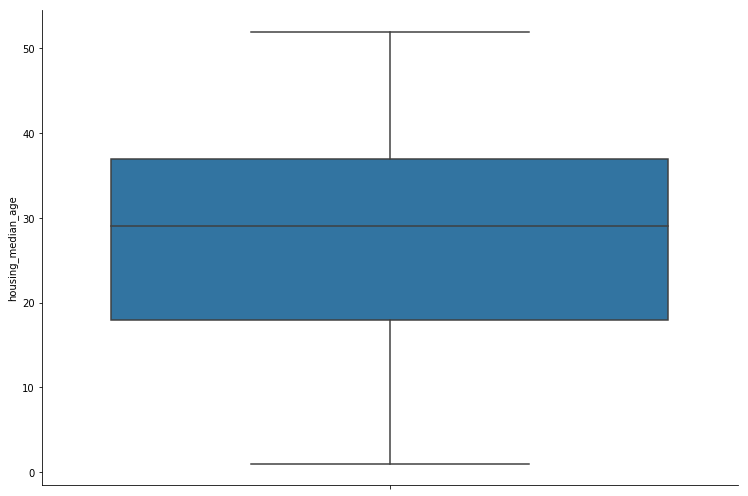

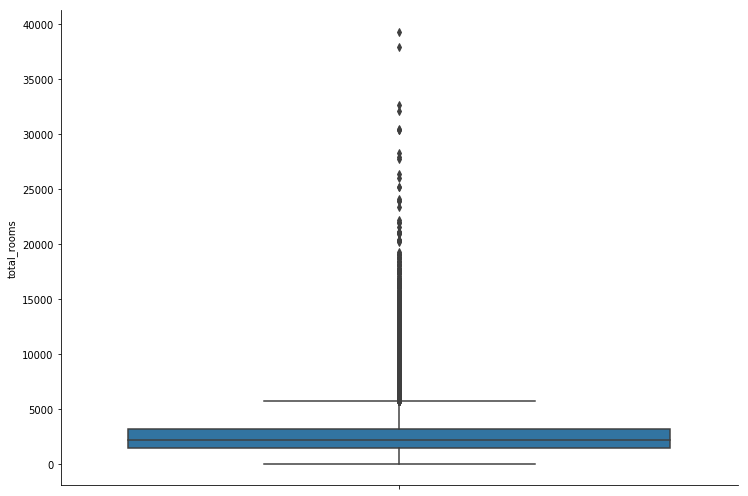

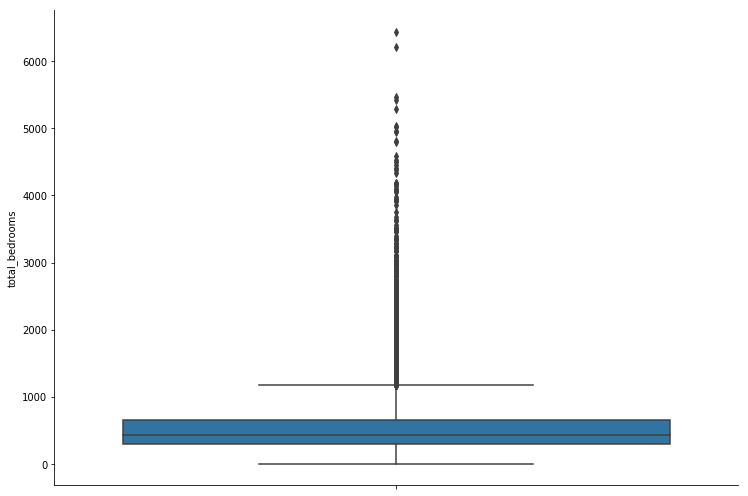

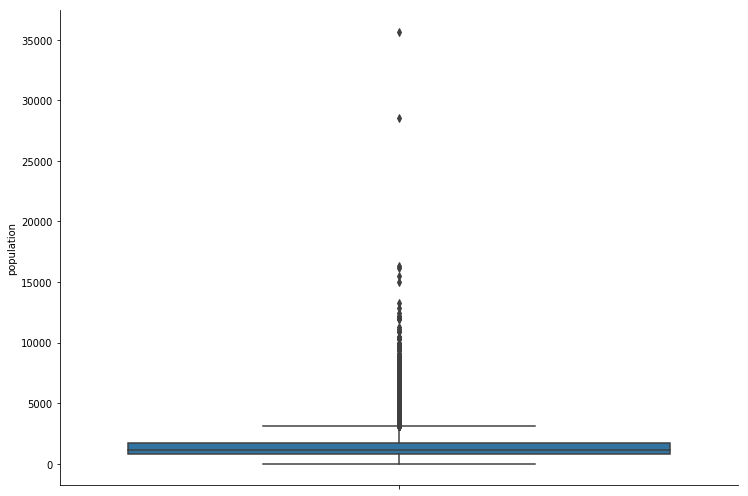

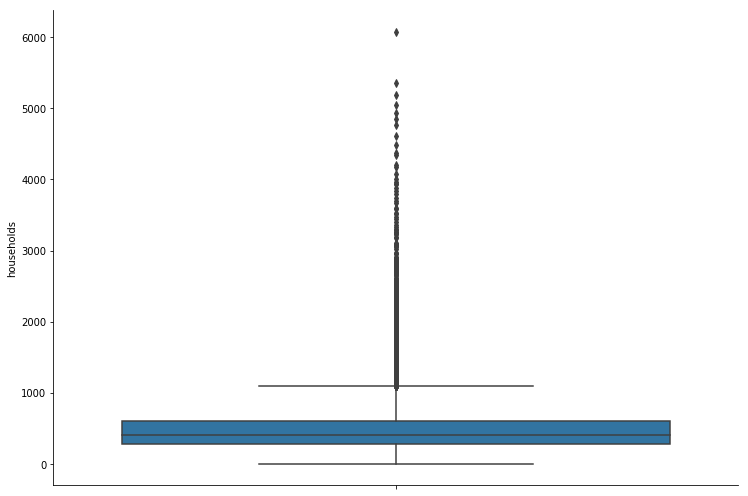

In [28]:
for i in df.columns:
    sns.factorplot(kind='box',
                   y=i,
                   data=df,
                   size=7,
                   aspect=1.5,
                   legend_out=False)

<br>
Los valores que se aprecian por encima del bigote superior no son outliers, sino que muestran una diferencia de tamaño entre los diferentes bloques del censo de California, concentrándose la mayoría en valores similares y unos pocos que son más grandes que el resto. No obstante, en prácticamente todas las variables se ve como unos pocos valores destacan más que los demás. Si los analizamos detallamadamente, podremos ver que pertecen a los mismos registros, como se muestra a continuación:

In [29]:
df[df.population > 15000]

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households
6057,253900,6.0191,8,32054,5290,15507,5050
6066,339700,6.6288,7,27700,4179,15037,4072
9880,118800,2.3087,11,32627,6445,28566,6082
10309,366300,7.4947,4,37937,5471,16122,5189
13139,153700,4.9516,3,39320,6210,16305,5358
15360,134400,2.5729,14,25135,4819,35682,4769


Por lo tanto, bastaría con borrar estos pocos registros para eliminar esos valores que destacan en todas las variables, con la siguiente condición:

In [30]:
df = df[df.population < 15000]

# 3. Selección del modelo de datos <a class="anchor" id="seleccion"></a>

Seleccionamos el modelo de datos

$$ln(median\_house\_value) = a_1 + a_2 \cdot median\_income + a_3 \cdot median\_income^2 + a_4 \cdot median\_income^3 + a_5 \cdot ln(median\_age) + a_6 \cdot ln(total\_room / population) + a_7 \cdot ln(total\_bedrooms / population) + a_8 \cdot ln(population / households) + a_9 \cdot ln(households)$$

<br>

In [31]:
df['ln_median_house_value'] = np.log(df.median_house_value)
df['ln_housing_median_age'] = np.log(df.housing_median_age)
df['ln_households'] = np.log(df.households)

df['median_income_2'] = df.median_income ** 2
df['median_income_3'] = df.median_income ** 3

df['ln_trooms_popul'] = np.log(df.total_rooms/df.population)
df['ln_tbedrooms_popul'] = np.log(df.total_bedrooms/df.population)
df['ln_popul_households'] = np.log(df.population/df.households)

In [32]:
df_model = df[['ln_median_house_value', 'median_income', 'median_income_2', 'median_income_3', 
               'ln_housing_median_age', 'ln_trooms_popul', 'ln_tbedrooms_popul', 
               'ln_popul_households', 'households']]
df_model.head()

,ln_median_house_value,median_income,median_income_2,median_income_3,ln_housing_median_age,ln_trooms_popul,ln_tbedrooms_popul,ln_popul_households,households
0,13.022764,8.3252,69.308955,577.010912,3.713572,1.005370,-0.914739,0.938270,126
1,12.789684,8.3014,68.913242,572.076387,3.044522,1.084069,-0.775135,0.746613,1138
2,12.771671,7.2574,52.669855,382.246204,3.951244,1.084399,-0.959552,1.030426,177
3,12.740517,5.6431,31.844578,179.702136,3.951244,0.825558,-0.864773,0.935287,219
4,12.743151,3.8462,14.793254,56.897815,3.951244,1.057667,-0.702036,0.779998,259


# 4. Separación de datos de entrenamiento y prueba <a class="anchor" id="train-test"></a>

In [33]:
from sklearn.model_selection import train_test_split

<br>
Separamos los datos en entrenamiento y prueba (30%) del conjunto de datos completo.

In [34]:
df_X = df_model.loc[:, df_model.columns != 'ln_median_house_value']
df_y = df_model.ln_median_house_value

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.30, 
                                                    random_state = 1234)

In [35]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (14443, 8)
X_test:  (6191, 8)
y_train: (14443,)
y_test:  (6191,)


# 5. Regresión lineal <a class="anchor" id="regresion-lineal"></a>

Se realizan dos modelos de regresión lineal. Uno será una regresión lineal básica sin ningún tipo de modificación de parámetros, y el otro será una regresión polinomial comprobando mediante *GridSearchCV* los valores {2, 3, 4}.

In [36]:
from sklearn.linear_model import LinearRegression

## 5.1. Regresión lineal básica <a class="anchor" id="regresion-lineal-basica"></a>

In [37]:
reg_LR = LinearRegression(normalize=True)
reg_LR_fit = reg_LR.fit(X_train, y_train)
y_pred_LR = reg_LR.predict(X_test)

In [61]:
print('Intercept: ', reg_LR.intercept_)

Intercept:  11.74956876472197


In [60]:
df_coef = pd.concat([pd.Series(X_train.columns), pd.Series(reg_LR.coef_)], axis=1)
df_coef.columns = ['Features', 'Coefficients']
df_coef

,Features,Coefficients
0,median_income,0.467644
1,median_income_2,-0.014773
2,median_income_3,-0.000256
3,ln_housing_median_age,0.161368
4,ln_trooms_popul,-0.854834
5,ln_tbedrooms_popul,0.790789
6,ln_popul_households,-0.434042
7,households,0.000094


In [40]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LR))
print('Variance score: %.2f' % r2_score(y_test, y_pred_LR))

Mean squared error: 0.13
Variance score: 0.61


## 5.2. Regresión lineal con variables polinomiales <a class="anchor" id="regresion-lineal-polinomial"></a>

In [62]:
poly = PolynomialFeatures()
scaler = MinMaxScaler()
lin_reg = LinearRegression(normalize=True)

## Pipeline steps
polynomial_step = ('poly', poly)
scaler_step = ('scaler', scaler)
lin_reg_step = ('lin_reg_step', lin_reg)
steps = [polynomial_step, scaler_step, lin_reg_step]
pipe = Pipeline(steps)

tuned_parameters = {'poly__degree': [2, 3, 4]}

kfold = KFold(n_splits = 10)

gs_lin_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_lin_reg.fit(X_train, y_train)

y_pred_lin_reg = gs_lin_reg.predict(X_test)

print("Best params: ", gs_lin_reg.best_params_)
print('\n')
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lin_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lin_reg))

Best params:  {'poly__degree': 2}


Mean squared error: 0.12
Variance score: 0.65


<br>
Observamos que el modelo que se ha hecho con variables polinómicas de segundo grado da un error cuadrático medio ligeramente más bajo que el modelo de regresión lineal básico.

# 6. Árboles de decisión <a class="anchor" id="arboles-decision"></a>

Los árboles de decisión son algoritmos de aprendizaje supervisado donde es posible visualizar el árbol de decisión entrenado, por lo que la interpretación de los resultados es más fácil. La forma en la que se genera un árbol de decisión es cogiendo el mejor atributo del conjunto de datos y situándolo en la *raíz* del árbol, para hacer un *split* y obtener un subconjunto de datos más pequeño. Posteriormente, se realizan estos mismos pasos en cada subconjunto de datos hasta encontrar los *nodos hoja* en cada una de las ramas del árbol.

Los árboles de decisión, aunque son fácilmente interpretables, sufren por tener una alta varianza y un pequeño cambio en los datos, puede cambiar el resultado final del árbol. Por este motivo, también se han realizado modelos con **Bagging**, **Random Forest** y **Boosting**, que veremos más adelante.

In [30]:
from sklearn.tree import DecisionTreeRegressor

## 6.1. Árbol de decisión básico <a class="anchor" id="arbol-decision-basico"></a>

En este caso probamos un árbol de decisión sin modificar ningún parámetro.

In [31]:
scaler = MinMaxScaler()
reg_DT = DecisionTreeRegressor()

scaler_step = ('scaler', scaler)
reg_DT_step = ('reg_DT', reg_DT)
steps = [scaler_step, reg_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred_reg_DT = pipe.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Mean squared error: 0.21
Variance score: 0.35


In [32]:
reg_DT.tree_.max_depth

37

<br>
Se observa que el error cuadrático medio es más alto que con la regresión lineal, el valor R2 es bajo y la profundidad del árbol es de 37. Esto podría indicar que prácticamente se está realizando un **Overfitting** sobre los datos de entrenamiento que hacen imposible predecir correctamente los datos de prueba. Por este motivo, es recomendable hacer un *GridSearchCV* para encontrar la profundidad máxima que ha de tener el árbol y el número mínimo de muestras necesarias para hacer un *split* o generar una hoja del árbol.

## 6.2. Árbol de decisión mediante GridSearch <a class="anchor" id="arbol-decision-gridsearch"></a>

In [33]:
scaler = MinMaxScaler()
reg_DT_gscv = DecisionTreeRegressor()

scaler_step = ('scaler', scaler)
reg_DT_gscv_step = ('reg_DT_gscv', reg_DT_gscv)
steps = [scaler_step, reg_DT_gscv_step]
pipe = Pipeline(steps)

params = {'reg_DT_gscv__max_depth': range(5, 20),
          'reg_DT_gscv__min_samples_split': range(2, 15),
          'reg_DT_gscv__min_samples_leaf': range(2, 36, 2)}

kfold = KFold(n_splits = 10)

gs_reg_DT = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_reg_DT.fit(X_train, y_train)

y_pred_reg_DT = gs_reg_DT.predict(X_test)

print("Best params: ", gs_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Best params:  {'reg_DT_gscv__min_samples_leaf': 26, 'reg_DT_gscv__max_depth': 10, 'reg_DT_gscv__min_samples_split': 11}
Mean squared error: 0.12
Variance score: 0.62


<br>
Vemos que la máxima profundidad que requiere el árbol es de 10, lo que podría indicar que considera prácticamente todas las variables como importantes o que hace un *split* de la misma variable varias veces. Por este motivo, vamos a estudiar a continuación qué variables son las más importantes para el árbol generado. Además, vemos que nos ha mejorado el error cuadrático medio, aunque únicamente en una centésima.

## 6.3. Visualización de las variables más importantes <a class="anchor" id="arbol-decision-variables"></a>

A partir de los mejores parámetros para el árbol encontrados en el anterior *GridSearchCV*, generamos el árbol.

In [45]:
scaler = MinMaxScaler()
reg_DT = DecisionTreeRegressor(max_depth = gs_reg_DT.best_params_['reg_DT_gscv__max_depth'], 
                               min_samples_leaf = gs_reg_DT.best_params_['reg_DT_gscv__min_samples_leaf'], 
                               min_samples_split = gs_reg_DT.best_params_['reg_DT_gscv__min_samples_split'])

scaler_step = ('scaler', scaler)
reg_DT_step = ('reg_DT', reg_DT)
steps = [scaler_step, reg_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reg_DT', DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=26,
           min_samples_split=11, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'))])

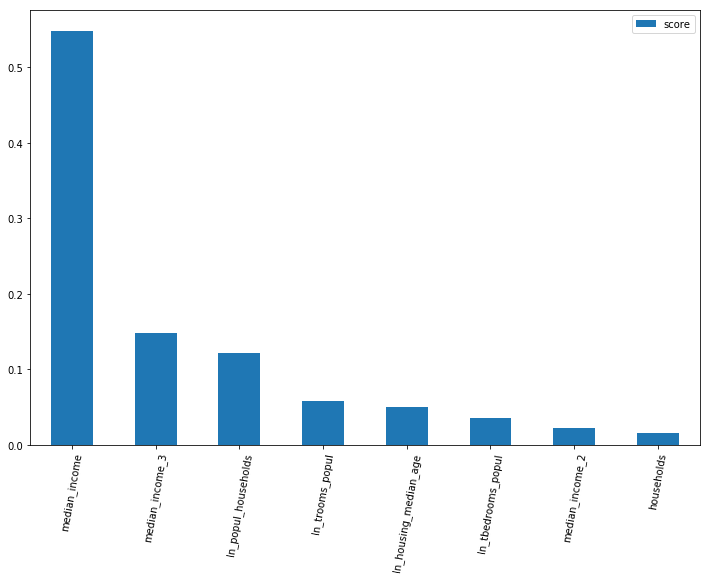

In [47]:
feat = pd.DataFrame(index=X_train.keys(), data=reg_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat.plot(kind='bar', rot=80)

La variable más importante para el árbol es **median_income**, siguiéndole **median\_income³** y **ln(population / households)**. La menos importante sería **households**.

# 7. Bagging <a class="anchor" id="bagging"></a>

Bagging, o *Bootstrap Aggregation*, es un procedimiento de propósito general para reducir la varianza de un método de aprendizaje estadístico. Hay que tener en cuenta que dado un conjunto de *n* observaciones $Z_1, ..., Z_n$, cada una con varianza $\sigma^2$, la varianza de la media $\overline{Z}$ de las observaciones está dada por $\sigma^2 / n$, es decir, con el promedio del conjunto de observaciones se reduce la varianza. 

Por lo tanto, Bagging utiliza Bootstrap para coger varias muestras de un único conjunto de entrenamiento y así generar *B* conjuntos de entrenamientos de *Boostrap*. Gracias a esto, y en combinación con los árboles de decisión, genera *B* árboles de decisión y hace el promedio del resultado de las predicciones reduciendo la varianza.

In [38]:
from sklearn.ensemble import BaggingRegressor

In [39]:
scaler = MinMaxScaler()
bag_reg_DT = BaggingRegressor(DecisionTreeRegressor(), oob_score=False)

scaler_step = ('scaler', scaler)
bag_reg_DT_step = ('bag_reg_DT', bag_reg_DT)
steps = [scaler_step, bag_reg_DT_step]
pipe = Pipeline(steps)

tuned_parameters = {'bag_reg_DT__n_estimators': range(250, 450, 10)}
kfold = KFold(n_splits = 10)

gs_bag_reg_DT = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_bag_reg_DT.fit(X_train, y_train)

y_pred_bag_reg_DT = gs_bag_reg_DT.predict(X_test)

print("Best params: ", gs_bag_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_bag_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_bag_reg_DT))

Best params:  {'bag_reg_DT__n_estimators': 310}
Mean squared error: 0.11
Variance score: 0.67


<br>
Observamos que ha mejorado el error cuadrático medio con respecto a los otros modelos. Esto podría deberse a la alta correlación entre las variables con la variable objetivo.

# 8. Random Forest <a class="anchor" id="random-forest"></a>

Random Forest provee una mejora sobre los árboles de decisión de Bagging para reducir más la varianza. Esto se hace de modo que cada vez que se hace una división en un árbol, se considera una selección aleatoria de *m* predictores elegidos como candidatos de división de todo el conjunto de *p* predictores. 

Normalmente se usan $m = \sqrt{p} \quad$  o  $\quad m = p$, y se pueden indicar en el siguiente algoritmo mediante el parámetro **max_features = 'sqrt'** o **max_features = 'auto'**, respectivamente. Además, con el parámetro **n_estimators** indicamos el número de árboles que se generan y con **max_depth** la profundidad de cada árbol. Estimamos la mejor combinación de estos parámetros mediante *GridSearchCV*.

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
scaler = MinMaxScaler()
rand_for_reg = RandomForestRegressor()

scaler_step = ('scaler', scaler)
rand_for_reg_step = ('rand_for_reg', rand_for_reg)
steps = [scaler_step, rand_for_reg_step]
pipe = Pipeline(steps)

tuned_parameters = {'rand_for_reg__n_estimators': range(140, 180, 5),
                    'rand_for_reg__max_features': ['sqrt', 'auto'],
                    'rand_for_reg__max_depth': range(15, 25),
                    'rand_for_reg__min_samples_split': range(10, 17),
                    'rand_for_reg__min_samples_leaf': range(2, 8)}

kfold = KFold(n_splits = 10)

gs_rand_for_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_reg.fit(X_train, y_train)

y_pred_rand_for_reg = gs_rand_for_reg.predict(X_test)

print("Best params: ", gs_rand_for_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rand_for_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_rand_for_reg))

Best params:  {'rand_for_reg__min_samples_split': 13, 'rand_for_reg__n_estimators': 160, 'rand_for_reg__min_samples_leaf': 5, 'rand_for_reg__max_features': 'auto', 'rand_for_reg__max_depth': 21}
Mean squared error: 0.11
Variance score: 0.68


Vemos que la profundidad de los árboles es más alto que la del árbol de decisión básico generado anteriormente. Esto puede ser debido a que se cogen los predictores al azar y cada árbol puede estar tomando como importantes otros predictores que el árbol de decisión básico no había tenido en cuenta.

## 8.1. Visualización de las variables más importantes <a class="anchor" id="random-forest-variables"></a>

A continuación, comprobamos cuáles son las variables que ha encontrado más importantes para generar los árboles aleatorios.

In [79]:
scaler = MinMaxScaler()
rand_for_reg = RandomForestRegressor(
                    max_depth = gs_rand_for_reg.best_params_['rand_for_reg__max_depth'], 
                    max_features = gs_rand_for_reg.best_params_['rand_for_reg__max_features'], 
                    n_estimators = gs_rand_for_reg.best_params_['rand_for_reg__n_estimators'], 
                    min_samples_split = gs_rand_for_reg.best_params_['rand_for_reg__min_samples_split'],
                    min_samples_leaf = gs_rand_for_reg.best_params_['rand_for_reg__min_samples_leaf'])

scaler_step = ('scaler', scaler)
rand_for_reg_step = ('rand_for_reg', rand_for_reg)
steps = [scaler_step, rand_for_reg_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rand_for_reg', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=13,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

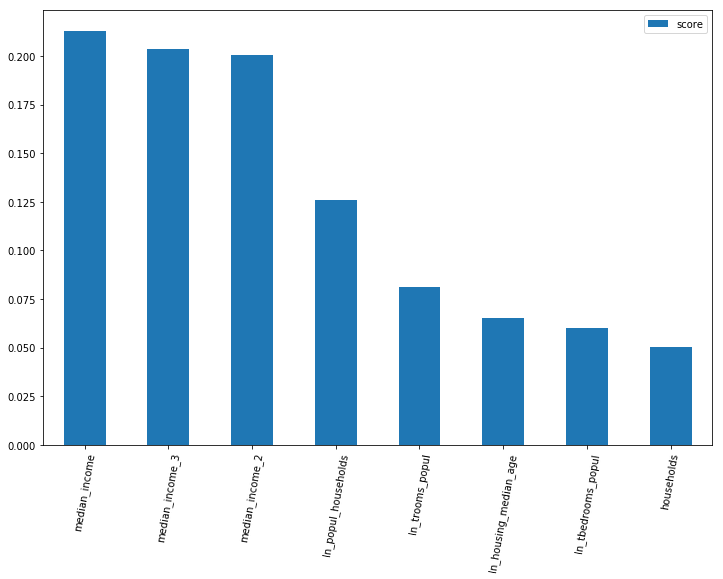

In [80]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_reg.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:25].plot(kind='bar', rot=80)

<br>
En este caso, la segunda variable más importante es **median_income^3**, siendo **median_income^2** la tercera, en comparación al árbol de decisión básico. La variable **households** sigue siendo la menos importante para los árboles aleatorios.

# 9. Boosting <a class="anchor" id="boosting"></a>

Así como Bagging implica la creación de múltiples copias del conjunto de entrenamiento original utilizando bootstrap, estimando un árbol de decisión independiente para cada copia, y luego combinando todos los árboles con el fin de crear un único modelo predictivo, Boosting hace que los árboles crezcan de forma secuencial, es decir, cada árbol crece utilizando la información de los árboles generados previamente.

In [50]:
from sklearn.ensemble import AdaBoostRegressor

In [51]:
scaler = MinMaxScaler()
ada_boost_reg = AdaBoostRegressor(DecisionTreeRegressor())

scaler_step = ('scaler', scaler)
ada_boost_reg_step = ('ada_boost_reg', ada_boost_reg)
steps = [scaler_step, ada_boost_reg_step]
pipe = Pipeline(steps)

tuned_parameters = {'ada_boost_reg__n_estimators': range(250, 450, 10)}
kfold = KFold(n_splits = 10)

gs_ada_boost_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_ada_boost_reg.fit(X_train, y_train)

y_pred_ada_boost_reg = gs_ada_boost_reg.predict(X_test)

print("Best params: ", gs_ada_boost_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ada_boost_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_ada_boost_reg))

Best params:  {'ada_boost_reg__n_estimators': 350}
Mean squared error: 0.11
Variance score: 0.67


<br>
El resultado del error cuadrático medio es el mismo que el de los árboles aleatorios, siendo estos dos los mejores modelos hasta el momento.

# 10. SVM <a class="anchor" id="svm"></a>

In [53]:
from sklearn.svm import SVR, NuSVR

A continuación, se prueban tres modelos de $\epsilon$-SVM con tres kernels diferentes: **lineal**, **Radial Basis Function (*RBF*)** y **polinomial** de grado 3, y un modelo de $\nu$-SVM con kernel **polinomial**. Los parámetros para los cuatro modelos son los mismos, exceptuando el parámetro **gamma** para el RBF y el parámetro **degree** para el polinomial.

Los parámetros a analizar mediante *GridSearchCV* son:

* **C**: parámetro de penalización del término de error. Cuanto mayor sea el valor de C, menor número de errores se permitiràn, por lo que si $C \to \infty$ se consideraría que todos los ejemplos son perfectamente separables. Cuanto más pequeño sea C, mayor número de errores se admitirían de ejemplos mal clasificados.
* **epsilon ($\epsilon$)**: solo se considera en las SVM de regresión. Especifica los valores para los que no hay penalización asociada en la función de pérdida del entrenamiento. El valor de $\epsilon$ afecta al número de vectores de soporte usados para construir la función de regresión. Cuando mayor sea el valor de $\epsilon$, menos vectores de soporte serán elegidos y más ancho será el canal.
* **nu ($\nu$)**: parámetro que controla el número de vectores de soporte y errores de entrenamiento.

Los parámetros que se espefican de manera fija son:

* **tol**: Tolerancia máxima aceptada para converger.
* **max_iter**: número máximo de iteraciones que se realizarían en caso de no haber convergido con la tolerancia especificada.

La formulación matemática para las SVM de regresión es la siguiente. Dados los vectores de entrenamiento $x_i \in \mathbb{R}^p, i = 1, ..., n$ y un vector $y \in \mathbb{R}^n$, $\epsilon-SVR$ resuelve el siguiente problema primal:

$$ min_{\omega, b, \xi^+, \xi^-} \frac{1}{2} \omega^T \omega + C \sum_{i=1}^n (\xi_{i}^+ + \xi_{i}^-)$$

sujeto a

$$ y_i - \omega^T \phi(x_i) - b \le \epsilon + \xi_{i}^+ $$
$$ \omega^T \phi(x_i) + b - y_i \lt \epsilon + \xi_{i}^- $$
$$ \xi_{i}^+ , \xi_{i}^- \ge 0, i = 1, ..., n $$

<img src="ep-SVR.png" width="500">

## 10.1. $\epsilon$-SVM con Kernel lineal <a class="anchor" id="epsvm-lineal"></a>

La función del kernel lineal es $\langle x, x' \rangle$.

In [57]:
scaler = MinMaxScaler()
svr_lin_reg = SVR(kernel='linear', 
                  shrinking=True, 
                  cache_size=4096, 
                  max_iter=1000000, 
                  tol=10e-4)

scaler_step = ('scaler', scaler)
svr_lin_reg_step = ('svr_lin_reg', svr_lin_reg)
steps = [scaler_step, svr_lin_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
epsilon = [0.00001, 0.0001, 0.001, 0.01]

tuned_parameters = {'svr_lin_reg__C': c, 
                    'svr_lin_reg__epsilon': epsilon}

kfold = KFold(n_splits = 10)

gs_svr_lin_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svr_lin_reg.fit(X_train, y_train)

y_pred_svr_lin_reg = gs_svr_lin_reg.predict(X_test)

print("Best params: ", gs_svr_lin_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svr_lin_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_svr_lin_reg))

Best params:  {'svr_lin_reg__C': 5, 'svr_lin_reg__epsilon': 0.0001}
Mean squared error: 0.13
Variance score: 0.61


## 10.2. $\epsilon$-SVM con Kernel RBF <a class="anchor" id="epsvm-rbf"></a>

Cuando se entrena una SVM con el kernel **RBF**, se han de tener en cuenta los parámetros *C* y *gamma*, entre los que existe un *trade-off*. El parámetro *gamma* define cuánta influencia tiene un único ejemplo del entrenamiento. Cuando más grande sea *gamma*, más cercanos han de estar otros ejemplos para ser afectados.

Si *gamma* es muy grande, el radio del área de influencia de los vectores de soporte solo incluye al propio soporte y *C* no tendrá ningún tipo de influencia. Por el contrario, cuando *gamma* es muy pequeño, el modelo queda muy limitado y no es capaz de ver toda la complejidad de los datos en el espacio de dimensiones. Cualquier vector de soporte incluirá todo el dataset de entrenamiento.

En la siguiente gráfica se puede observar dicho *trade-off*:

![Validation accuracy](http://scikit-learn.org/stable/_images/sphx_glr_plot_rbf_parameters_002.png)

Por este motivo, para el *GridSearchCV* se han escogido unos valores de *gamma* de {0.001, 0.01, 0.1, 1, 10}, dado que la *C* podrá tener los valores {0.001, 0.01, 0.1, 1, 5, 10, 100}.

La función del kernel radial es $exp(-\gamma \| x - x'\|^2)$, donde $\gamma$ es el parámetro *gamma*.

In [58]:
scaler = MinMaxScaler()
svr_rbf_reg = SVR(kernel='rbf', 
                  shrinking=True, 
                  cache_size=4096, 
                  max_iter=1000000, 
                  tol=10e-4)

scaler_step = ('scaler', scaler)
svr_rbf_reg_step = ('svr_rbf_reg', svr_rbf_reg)
steps = [scaler_step, svr_rbf_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]
epsilon = [0.001, 0.01, 0.1, 1]

tuned_parameters = {'svr_rbf_reg__C': c, 
                    'svr_rbf_reg__gamma': gamma, 
                    'svr_rbf_reg__epsilon': epsilon}

kfold = KFold(n_splits = 10)

gs_svr_rbf_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svr_rbf_reg.fit(X_train, y_train)

y_pred_svr_rbf_reg = gs_svr_rbf_reg.predict(X_test)

print("Best params: ", gs_svr_rbf_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svr_rbf_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_svr_rbf_reg))

Best params:  {'svr_rbf_reg__C': 10, 'svr_rbf_reg__gamma': 10, 'svr_rbf_reg__epsilon': 0.1}
Mean squared error: 0.11
Variance score: 0.67


## 10.3. $\epsilon$-SVM con Kernel polinomial <a class="anchor" id="epsvm-poly"></a>

La función del kernel polinolial es $(\gamma \langle x, x' \rangle + r)^d$, donde $d$ es el parámetro *degree*, $r$ el parámetro *coef0* (por defecto es 0) y $\gamma$ es el parámetro *gamma*.

In [22]:
scaler = MinMaxScaler()
svr_ps_reg = SVR(kernel='poly', 
                 shrinking=True, 
                 cache_size=4096, 
                 max_iter=10000000, 
                 tol=10e-2, 
                 degree=3)

scaler_step = ('scaler', scaler)
svr_ps_reg_step = ('svr_ps_reg', svr_ps_reg)
steps = [scaler_step, svr_ps_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.001, 0.01, 0.1, 1, 10]
epsilon = [0.001, 0.01, 0.1, 1]

tuned_parameters = {'svr_ps_reg__C': c, 
                    'svr_ps_reg__gamma': gamma,
                    'svr_ps_reg__epsilon': epsilon}

kfold = KFold(n_splits = 10)

gs_svr_ps_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svr_ps_reg.fit(X_train, y_train)

y_pred_svr_ps_reg = gs_svr_ps_reg.predict(X_test)

print("Best params: ", gs_svr_ps_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svr_ps_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_svr_ps_reg))

Best params:  {'svr_ps_reg__gamma': 10, 'svr_ps_reg__C': 0.1, 'svr_ps_reg__epsilon': 0.001}
Mean squared error: 0.11
Variance score: 0.65


## 10.4. $\nu$-SVM con Kernel RBF <a class="anchor" id="nusvm-rbf"></a>

Por último, ejecutamos el modelo $\nu$-SVM con Kernel RBF.

In [87]:
scaler = MinMaxScaler()
nusvr_rbf_reg = NuSVR(kernel='rbf', 
                      shrinking=True, 
                      cache_size=4096, 
                      max_iter=1000000, 
                      tol=10e-3)

scaler_step = ('scaler', scaler)
nusvr_rbf_reg_step = ('nusvr_rbf_reg', nusvr_rbf_reg)
steps = [scaler_step, nusvr_rbf_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10, 100]
gamma = [0.01, 0.1, 1, 10]
nu = [0.2, 0.4, 0.5, 0.6, 0.8]

tuned_parameters = {'nusvr_rbf_reg__C': c, 
                    'nusvr_rbf_reg__gamma': gamma, 
                    'nusvr_rbf_reg__nu': nu}

kfold = KFold(n_splits = 10)

gs_nusvr_rbf_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=True)
gs_nusvr_rbf_reg.fit(X_train, y_train)

y_pred_nusvr_rbf_reg = gs_nusvr_rbf_reg.predict(X_test)

print("Best params: ", gs_nusvr_rbf_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_nusvr_rbf_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_nusvr_rbf_reg))

Best params:  {'nusvr_rbf_reg__nu': 0.8, 'nusvr_rbf_reg__gamma': 10, 'nusvr_rbf_reg__C': 10}
Mean squared error: 0.11
Variance score: 0.67


## 10.5. Conclusiones de SVM <a class="anchor" id="svm-result"></a>

Los resultados finales de los modelos de SVM anteriores han sido:

In [94]:
svm_models = ['ep-SVM con kernel lineal', 'ep-SVM con kernel RBF', 
              'ep-SVM con kernel polinomial', 'nu-SVM con kernel RBF']
C = [5, 10, 10, 10]
gamma = ['-', 10, 10, 10]
epsilon = [0.0001, 0.1, 0.001, '-']
nu = ['-', '-', '-', 0.8]
MSE = [0.13, 0.11, 0.11, 0.11]
R2 = [0.61, 0.67, 0.65, 0.67]

df_svm_models = pd.concat([pd.Series(svm_models), pd.Series(C), pd.Series(gamma),
                          pd.Series(epsilon), pd.Series(nu), 
                          pd.Series(MSE), pd.Series(R2)], axis=1)
df_svm_models.columns = ['SVM Model', 'C', 'gamma', 'epsilon', 'nu', 'MSE', 'R2']
df_svm_models

,SVM Model,C,gamma,epsilon,nu,MSE,R2
0,ep-SVM con kernel lineal,5,-,0.0001,-,0.13,0.61
1,ep-SVM con kernel RBF,10,10,0.1,-,0.11,0.67
2,ep-SVM con kernel polinomial,10,10,0.001,-,0.11,0.65
3,nu-SVM con kernel RBF,10,10,-,0.8,0.11,0.67


<br>
Los mejores modelos han sido los del kernel **RBF**, con un *Mean Square Error* de 0.11 y un $R^2$ de 0.67. El peor ha sido el modelo con kernel polinomial.

El modelo lineal es el que ha tenido un valor de *C* más pequeño, permitiendo un mayor número de errores que el resto de modelos. También el valor de $\epsilon$ es el más pequeño, por lo que el canal es más estrecho en comparación al de los otro modelos. Debido a esto, los valores de $\xi_{i}^+, \xi_{i}^-$ son mayores, lo que provoca que *C* sea más pequeño.

Los modelos de $\epsilon$-SVM con kernel **RBF** y **polinomial** se diferencian únicamente en el valor de $\epsilon$, a pesar de que los parámetros *C* y $\gamma$ son los mismos. Esto puede deberse a la influencia del parámetro $\gamma$ y a que los valores de $\xi_{i}^+, \xi_{i}^-$ se mantengan proporcionales al valor de $\epsilon$, provocando que *C* no se vea alterada. No obstante, para cualquier otro valor de $\gamma$ mayor que el que tenemos tendríamos valores de *accuracy* muy bajos y por este motivo no se han probado otros valores de $\gamma$ en el *GridSearchCV*.

# 11. Redes neuronales <a class="anchor" id="neural-net"></a>

In [38]:
from sklearn.neural_network import MLPRegressor

Generamos varias combinaciones de número de neuronas en una, dos y tres capas.

In [39]:
import itertools

n_neurons = [1, 3, 5, 10]
hidden_layer_sizes = n_neurons

for two_layer in itertools.product(n_neurons, repeat=2):
    hidden_layer_sizes.append(two_layer)

n_neurons = [1, 3, 5]
for three_layer in itertools.product(n_neurons, repeat=3):
    hidden_layer_sizes.append(three_layer)
    
hidden_layer_sizes

[1,
 3,
 5,
 10,
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 10),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 10),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 10),
 (10, 1),
 (10, 3),
 (10, 5),
 (10, 10),
 (1, 1, 1),
 (1, 1, 3),
 (1, 1, 5),
 (1, 3, 1),
 (1, 3, 3),
 (1, 3, 5),
 (1, 5, 1),
 (1, 5, 3),
 (1, 5, 5),
 (3, 1, 1),
 (3, 1, 3),
 (3, 1, 5),
 (3, 3, 1),
 (3, 3, 3),
 (3, 3, 5),
 (3, 5, 1),
 (3, 5, 3),
 (3, 5, 5),
 (5, 1, 1),
 (5, 1, 3),
 (5, 1, 5),
 (5, 3, 1),
 (5, 3, 3),
 (5, 3, 5),
 (5, 5, 1),
 (5, 5, 3),
 (5, 5, 5)]

A continuación, se realiza un *GridSearchCV* para todas estas posibilidades de redes neuronales, con un *alpha* (Penalizació L2) de {0.0001, 0.001, 0.01} y un *learning rate* constante de {0.001, 0.01, 0.1}.

La función de optimización usada es **adam**, la cual hace referencia al optimizador de descendiente del gradiente estocástico propuesto por Kingma, Diederik y Jimmy Ba.

Se han probado las funciones de activación **ReLU**, **logistic** y **tanh** en varias ejecucions con diferentes parámetros para el GridSeach y siempre ha salido que la más óptima es **ReLU**, por lo tanto, especificamos este parámetro fuera del *GridSearchCV* y, de esta manera, se pueden probar (con un tiempo de ejecución razonable) los parámetros **beta_1** y **beta_2** para la función de optimización **adam**. Esto se hace así para que se ejecute todo en un tiempo razonable de tiempo.

In [52]:
scaler = MinMaxScaler()
mlp_reg = MLPRegressor(solver='adam',
                       max_iter=5000, 
                       activation='relu')

scaler_step = ('scaler', scaler)
mlp_reg_step = ('mlp_reg', mlp_reg)
steps = [scaler_step, mlp_reg_step]
pipe = Pipeline(steps)

alpha = [0.0001, 0.001, 0.01]
learning_rate_init = [0.001, 0.01, 0.1]
beta_1 = [0.8, 0.9, 0.999]
beta_2 = [0.8, 0.9]

tuned_parameters = {'mlp_reg__alpha': alpha,
                    'mlp_reg__learning_rate_init': learning_rate_init, 
                    'mlp_reg__hidden_layer_sizes': hidden_layer_sizes, 
                    'mlp_reg__beta_1': beta_1, 
                    'mlp_reg__beta_2': beta_2}

kfold = KFold(n_splits = 5)

gs_mlp_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_mlp_reg.fit(X_train, y_train)

y_pred_mlp_reg = gs_mlp_reg.predict(X_test)

print("Best params: ", gs_mlp_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_mlp_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_mlp_reg))

Best params:  {'mlp_reg__hidden_layer_sizes': (10, 3), 'mlp_reg__learning_rate_init': 0.01, 'mlp_reg__alpha': 0.001, 'mlp_reg__beta_1': 0.9, 'mlp_reg__beta_2': 0.9}
Mean squared error: 0.14
Variance score: 0.57


<br>
La mejor red neuronal de las propuestas ha sido la de 2 capas ocultas, donde la primera capa tiene 10 neuronas y la segunda tiene 3 neuronas, y con un valor de **alpha** igual a 0.001. No obstante, ha sido el peor modelo de todos los probados.

# 12. Resultados finales <a class="anchor" id="results"></a>

Los resultados finales de todos los modelos son los siguientes:

In [95]:
models = ['Regresión lineal básico', 'Regresión lineal con variables polinomiales', 
          'Árbol de decisión', 'Bagging', 'Random forest', 'Boosting', 
          'ep-SVM con kernel lineal', 'ep-SVM con kernel RBF', 
          'ep-SVM con kernel polinomial', 'nu-SVM con kernel RBF', 'Redes neuronales']
MSE = [0.13, 0.12, 0.12, 0.11, 0.11, 0.11, 0.13, 0.11, 0.11, 0.11, 0.14]
R2 = [0.61, 0.65, 0.62, 0.67, 0.68, 0.67, 0.61, 0.67, 0.65, 0.67, 0.57]

df_models = pd.concat([pd.Series(models), pd.Series(MSE), pd.Series(R2)], axis=1)
df_models.columns = ['Model', 'MSE', 'R2']
df_models

,Model,MSE,R2
0,Regresión lineal básico,0.13,0.61
1,Regresión lineal con variables polinomiales,0.12,0.65
2,Árbol de decisión,0.12,0.62
3,Bagging,0.11,0.67
4,Random forest,0.11,0.68
5,Boosting,0.11,0.67
6,ep-SVM con kernel lineal,0.13,0.61
7,ep-SVM con kernel RBF,0.11,0.67
8,ep-SVM con kernel polinomial,0.11,0.65
9,nu-SVM con kernel RBF,0.11,0.67


<br>
El mejor modelo ha sido **Random Forest** con un MSE de 0.11 y un $R^2$ de 0.68. Por detrás de él están los modelos **Bagging**, **Boosting** y los modelos de SVM con kernel **RBF** con un MSE de 0.11 y un $R^2$ de 0.67.

Los modelos de redes neuronales, SVM con kernel lineal y la regresión lineal básica han sido los peores modelos.

El modelo que usaría para predecir la variable $ln(median\_house\_value)$ sería **Random Forest**.